In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import multiprocessing
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", level=logging.INFO)

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print(cores)

# Implementing the Node2Vec paradigm
## Algorithm
- We are given an adjacency matrix -> this acts as a set of rules (vocabulary)
- We are going to generate linear chains to be able to predict the context/neighborhood of a given node
- So, using the adjacency matrix, we generate many random walks of a fixed length.
- The random walks will become our dataset to feed and train the `SkipGram` model.

In [ ]:
class Node2Vec():
        def __init__(
                        self, 
                        graph : "list[list[int]]", 
                        window_size : int, 
                        embedding_size : int, 
                        walks_per_vertex : int, 
                        walk_length : int,
                        p : float,
                        q : float
                ) -> None:
                """
                Initialize the DeepWalk model. This directly from the paper https://arxiv.org/pdf/1403.6652.pdf.

                Parameters
                ----------
                graph : list[list[int]]
                        The adjacency list to be embedded. This is a list of lists, where each list is a vertex and its neighbors.
                window_size : int
                        The window size for the skipgram model.
                embedding_size : int
                        The size of the embedding. The final output matrix will be of size |V| x embedding_size.
                walks_per_vertex : int
                        The number of walks to perform per vertex.
                walk_length : int
                        The length of each walk.
                p : float
                        The return parameter.
                q : float
                        The in-out parameter.

                Methods
                -------
                generate_n_walks()
                        Generate n walks from the graph.
                train()
                        Train the model.
                update()
                        Feed model new walks.
                get_embeddings()
                        Return the embeddings.
                """

                # DeepWalk parameters
                self.g = graph
                self.w = window_size
                self.d = embedding_size
                self.gamma = walks_per_vertex
                self.epochs = self.gamma
                self.t = walk_length
                self.n = len(graph)
                self.p = p
                self.q = q

        def second_order_biased_random_walk(
                        self,
                        adj_mat : 'list[list[int]]', 
                        walk_len : 'int', 
                        start_node : 'int', 
                        return_parameter :'float', 
                        in_out_parameter : 'float'
                        ) -> np.array:
                """
                Return a walk based on a 2nd order Markov Chain like transition.

                Parameters
                ----------
                adj_mat : list[list[int]]
                        Adjacency matrix of the graph.
                walk_len : int
                        Length of the random walk.
                start_node : int
                        Starting node of the random walk.
                return_parameter : float
                        The value of the "p" parameter
                in_out_parameter : float
                        The value of the "q" parameter
                
                Returns
                -------
                np.array
                        List of nodes in the random walk.  
                
                """
                # Array to store the walk
                walk = [
                        start_node, # Extra node to help uniformly sample the second node
                        start_node  # The actual walk we will return is walk
                ]

                # Make an adjacency list to easily 
                # sample the neighbors of a node.
                adj_list = [] # list of [node, weight]
                for i in range(len(adj_mat)):
                        neighbors = np.where(adj_mat[i] > 0)[0]  # Get neighbor indices
                        weights = adj_mat[i, neighbors]  # Get corresponding edge weights
                        adj_list.append(list(zip(neighbors, weights)))

                # Keep walking for walk_len epochs
                for walk_step in range(walk_len):
                        # 1) Assign a value of 1 / in_out 
                        #    to all neighbours of walk[-1]
                        # 2) Overwrite the value of all 
                        #    neighbours of walk[-2] with 1 
                        # 3) Overwrite walk[-2] by 1
                        # 4) Multiply each element by the 
                        #    weight of the corresponding edge. 
                        # Feed it to np.random.choice

                        # Current and Parent node 
                        curr_node = walk[-1]
                        prev_node = walk[-2]

                        # Using the parent_node id get the neighbours and their weights
                        neighbors, weights = zip(*adj_list[curr_node])
                        prev_neighbors, prev_weights = zip(*adj_list[prev_node])

                        # Get boolean arrays to mark current neighbours as previous node's neighbours
                        is_prev_neighbor = np.isin(neighbors, prev_neighbors)
                        is_prev_node = np.isin(np.array([prev_node]), neighbors)

                        # print(is_prev_neighbor, is_prev_node)
                        
                        # Calculate probabilities based on the return and in-out parameters
                        probabilities = np.zeros(len(neighbors), dtype=np.float64)
                        
                        probabilities[is_prev_node] = 1.0 / return_parameter
                        probabilities[is_prev_neighbor] = 1.0
                        probabilities[~(is_prev_node | is_prev_neighbor)] = 1.0 / in_out_parameter

                        # Normalize the probabilities
                        probabilities /= np.sum(probabilities)

                        # Multiply each element by the weight of the corresponding edge
                        weighted_probabilities = probabilities * weights
                        # weighted_probabilities = probabilities

                        # Choose the next node based on the probabilities
                        next_node = np.random.choice(neighbors, p=weighted_probabilities / np.sum(weighted_probabilities))

                        walk.append(next_node)


                return np.array(walk[1:])

        def generate_n_walks(self, num_iters : int) -> 'list[list[str]]':
                """
                Generate a list of num_iters random walks. These will be used to train the model

                Parameters
                ----------
                num_iters : int
                        Number of walks to generate.

                Returns
                -------
                np.ndarray
                        List of random walks.
                """

                # List to store the walks
                walks = []

                # For each vertex in the graph
                for vertex in range(self.n):
                        # Generate gamma walks of length t
                        for _ in range(self.gamma):
                                walks.append(self.second_order_biased_random_walk(self.g, self.t, vertex, self.p, self.q))

                walks = [[str(node) for node in walk] for walk in walks]

                return walks

        def train(self, epochs : int, lr : float) -> None:
                """
                Train the model.

                Parameters
                ----------
                epochs : int
                        Number of epochs to train the model for.
                lr : float
                        Learning rate for the optimizer.                
                """

                # Generate many walks
                walks = self.generate_n_walks(self.gamma)

                # Initialize the model
                self.model = Word2Vec(
                        walks,
                        negative= 10,
                        sg=1,
                        alpha=0.05,
                        epochs=self.epochs, 
                        vector_size=self.d,        # embedding dimension
                        window=self.w,             # context window size
                        min_count=0,
                        workers=cores-2
                )

        def get_embeddings(self) -> np.ndarray:
                """
                Return the embeddings.

                Returns
                -------
                np.ndarray
                        Embeddings.
                """
                return [self.model.wv[str(n)] for n in range(self.n)]
        
        def plot_embeddings(self, num_dimensions : int, gt_labels : 'list[str]') -> None:
                """
                Plot the embeddings.

                Parameters
                ----------
                num_dimensions : int
                        Number of dimensions to plot.
                gt_labels : list[str]
                        List of ground truth labels.
                """
                embeddings = np.array(self.get_embeddings())

                # dimensionality reduction to 2 dimensions using t-SNE for visualization
                embeddings = TSNE(n_components=2).fit_transform(embeddings)

                # Convert gt into numbers
                gt_labels = np.array(gt_labels)

                # Iterate over all labels and assign them an integer
                for i, label in enumerate(np.unique(gt_labels)):
                        gt_labels[gt_labels == label] = i
                gt_labels = gt_labels.astype(int)

                # plot the embeddings
                plt.figure(figsize=(6,6))
                plt.scatter(embeddings[:,0], embeddings[:,1], c=gt_labels)

                # Plot node numbers
                for i in range(len(embeddings)):
                        plt.annotate(i , (embeddings[i,0], embeddings[i,1]))
                        
                plt.show()

In [ ]:
def plot_graph ( G , node_colours):
    plt.figure(figsize=(8,8))
    # scale node size by degree
    node_sizes = [v * 20 for v in dict(G.degree()).values()]
    nx.draw_networkx(G, with_labels=False, node_color= node_colours, node_size= node_sizes,edgecolors="black", alpha=0.9)
    plt.axis("off")
    plt.show()

## Showing DeepWalk

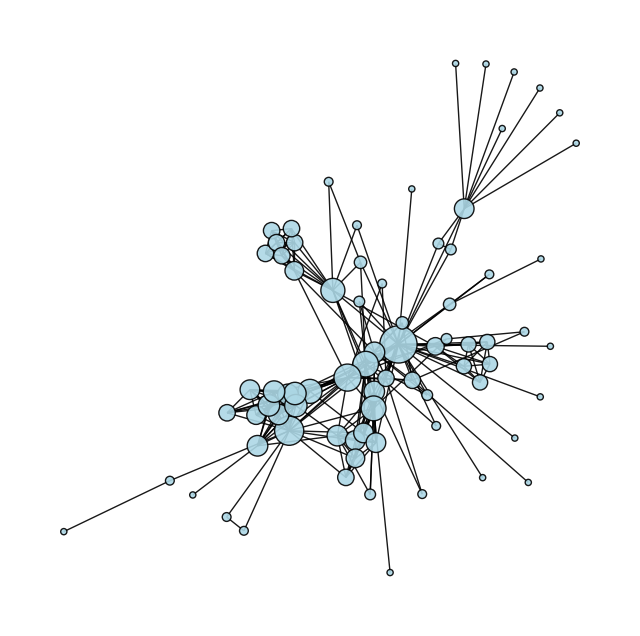

In [ ]:
G = nx.les_miserables_graph()
# draw a graph with light blue nodes outlined with black and grey edges (without labels)
plot_graph(G, "lightblue")

adjmat = nx.adjacency_matrix(G).todense()

In [ ]:
# adjmat , window_size , embedding_size , walks_per_vertex , walk_length , p , q
n2v = Node2Vec(adjmat, 10, 128, 10, 80, 1, 1)

In [ ]:
n2v.train(30, 0.05)

INFO - 2023-10-26 19:47:36,850: collecting all words and their counts
INFO - 2023-10-26 19:47:36,851: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2023-10-26 19:47:36,855: collected 77 word types from a corpus of 62370 raw words and 770 sentences
INFO - 2023-10-26 19:47:36,855: Creating a fresh vocabulary
INFO - 2023-10-26 19:47:36,856: Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 77 unique words (100.00% of original 77, drops 0)', 'datetime': '2023-10-26T19:47:36.856135', 'gensim': '4.3.2', 'python': '3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]', 'platform': 'Linux-5.15.0-87-generic-x86_64-with-glibc2.31', 'event': 'prepare_vocab'}
INFO - 2023-10-26 19:47:36,856: Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 62370 word corpus (100.00% of original 62370, drops 0)', 'datetime': '2023-10-26T19:47:36.856328', 'gensim': '4.3.2', 'python': '3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]', 'platform': 'Linux-5.15.0-87-g

In [ ]:
# n2v.plot_embeddings(2, gt)

In [ ]:
# # getting the embeddings from the model
embeddings = np.array(n2v.get_embeddings())

# from sknetwork.clustering import Louvain, get_modularity
# import scipy.sparse as sp
# from sknetwork.visualization import svg_graph, svg_bigraph

# louvain = Louvain()
# labels = louvain.fit_predict(adjmat)

In [ ]:
# G = nx.karate_club_graph()
# nx.draw(G, with_labels=True, node_color=labels, cmap=plt.cm.rainbow)
# adjmat = nx.adjacency_matrix(G).todense()

In [ ]:
# n2v.plot_embeddings(2, labels)

## Showing Homophily

INFO - 2023-10-26 19:47:43,052: collecting all words and their counts
INFO - 2023-10-26 19:47:43,053: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2023-10-26 19:47:43,059: collected 77 word types from a corpus of 62370 raw words and 770 sentences
INFO - 2023-10-26 19:47:43,059: Creating a fresh vocabulary
INFO - 2023-10-26 19:47:43,060: Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 77 unique words (100.00% of original 77, drops 0)', 'datetime': '2023-10-26T19:47:43.060753', 'gensim': '4.3.2', 'python': '3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]', 'platform': 'Linux-5.15.0-87-generic-x86_64-with-glibc2.31', 'event': 'prepare_vocab'}
INFO - 2023-10-26 19:47:43,061: Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 62370 word corpus (100.00% of original 62370, drops 0)', 'datetime': '2023-10-26T19:47:43.061213', 'gensim': '4.3.2', 'python': '3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]', 'platform': 'Linux-5.15.0-87-g

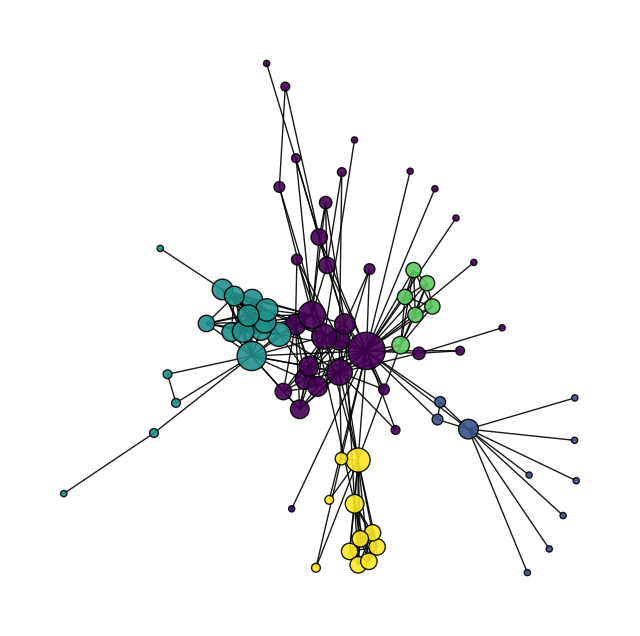

In [ ]:
''' do k means clustering for different p and q values and assign 
colours to the nodes based on the cluster they belong to '''

# p = 1, q=0.5
n2v = Node2Vec(adjmat, 10, 128, 10, 80, 1, 0.5)
n2v.train(30, 0.05)
embeddings = np.array(n2v.get_embeddings())

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0,n_init=10).fit(embeddings)
labels = kmeans.labels_

plot_graph(G, labels)


## Showing Structural Equivalence

INFO - 2023-10-26 19:47:49,146: collecting all words and their counts
INFO - 2023-10-26 19:47:49,146: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2023-10-26 19:47:49,151: collected 77 word types from a corpus of 62370 raw words and 770 sentences
INFO - 2023-10-26 19:47:49,151: Creating a fresh vocabulary
INFO - 2023-10-26 19:47:49,152: Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 77 unique words (100.00% of original 77, drops 0)', 'datetime': '2023-10-26T19:47:49.152320', 'gensim': '4.3.2', 'python': '3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]', 'platform': 'Linux-5.15.0-87-generic-x86_64-with-glibc2.31', 'event': 'prepare_vocab'}
INFO - 2023-10-26 19:47:49,152: Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 62370 word corpus (100.00% of original 62370, drops 0)', 'datetime': '2023-10-26T19:47:49.152583', 'gensim': '4.3.2', 'python': '3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]', 'platform': 'Linux-5.15.0-87-g

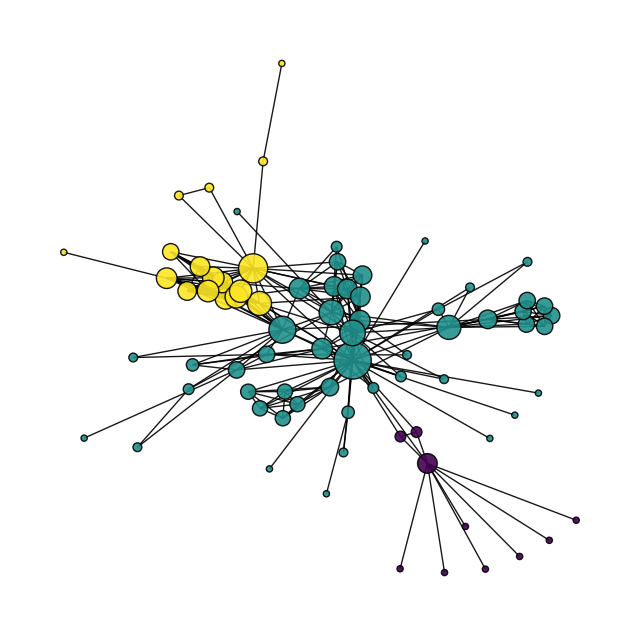

In [ ]:
# p = 1, q=2
n2v = Node2Vec(adjmat, 10, 128, 10, 80, 1, 2)
n2v.train(30, 0.05)
embeddings = np.array(n2v.get_embeddings())

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0,n_init=10).fit(embeddings)
labels = kmeans.labels_
plot_graph(G, labels)

/tmp/ipykernel_9129/1576803452.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Cluster')


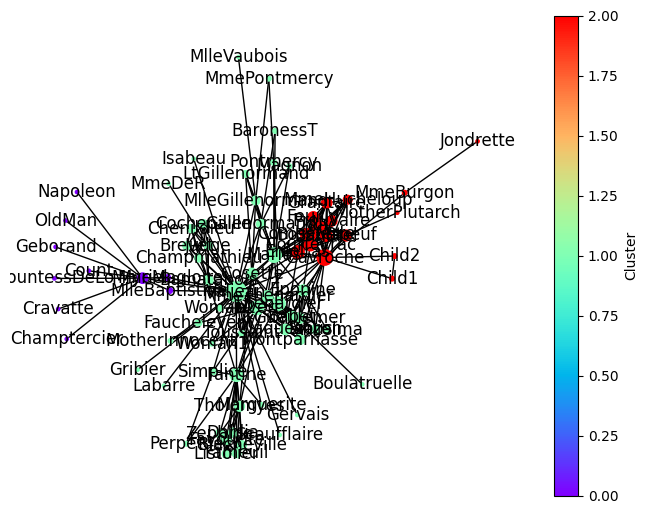

In [ ]:
# Compute node degrees
node_degrees = dict(G.degree())

# Determine the maximum degree for scaling node sizes
max_degree = max(node_degrees.values())

# Define a scaling factor for node sizes
scale_factor = 200  # Adjust this as needed to control the node size

# Compute node sizes proportional to their degree
node_sizes = [scale_factor * node_degrees[node] / max_degree for node in G.nodes]

# Plot the graph with nodes sized by their degree
pos = nx.spring_layout(G)  # Use a layout algorithm that suits your needs
nx.draw(G, pos, with_labels=True, node_color=labels, cmap=plt.cm.rainbow, node_size=node_sizes)

# Add colorbar for node colors
sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=plt.Normalize(vmin=min(labels), vmax=max(labels)))
sm.set_array([])
plt.colorbar(sm, label='Cluster')
plt.show()

In [ ]:
class Node2Vec():
        def __init__(
                        self, 
                        graph : "list[list[int]]", 
                        window_size : int, 
                        embedding_size : int, 
                        walks_per_vertex : int, 
                        walk_length : int,
                        p : float,
                        q : float
                ) -> None:
                """
                Initialize the DeepWalk model. This directly from the paper https://arxiv.org/pdf/1403.6652.pdf.

                Parameters
                ----------
                graph : list[list[int]]
                        The adjacency list to be embedded. This is a list of lists, where each list is a vertex and its neighbors.
                window_size : int
                        The window size for the skipgram model.
                embedding_size : int
                        The size of the embedding. The final output matrix will be of size |V| x embedding_size.
                walks_per_vertex : int
                        The number of walks to perform per vertex.
                walk_length : int
                        The length of each walk.
                p : float
                        The return parameter.
                q : float
                        The in-out parameter.

                Methods
                -------
                generate_n_walks()
                        Generate n walks from the graph.
                train()
                        Train the model.
                update()
                        Feed model new walks.
                get_embeddings()
                        Return the embeddings.
                """

                # DeepWalk parameters
                self.g = graph
                self.w = window_size
                self.d = embedding_size
                self.gamma = walks_per_vertex
                self.epochs = self.gamma
                self.t = walk_length
                self.n = len(graph)
                self.p = p
                self.q = q
                
                # Make the adjacency list using the graph
                self.adj_list = []
                for i in range(len(self.g)):
                        neighbors = np.where(self.g[i] > 0)[0]  # Get neighbor indices
                        weights = self.g[i, neighbors]  # Get corresponding edge weights
                        self.adj_list.append(list(zip(neighbors, weights)))
                
        def alias_setup(self, probs):
                """
                Taken from
                https://lips.cs.princeton.edu/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
                """
                # Turning into a normal array 
                probs = list(probs)
            
                K       = len(probs)
                q       = np.zeros(K)
                J       = np.zeros(K, dtype=np.int)

                # Sort the data into the outcomes with probabilities
                # that are larger and smaller than 1/K.
                smaller = []
                larger  = []
                for kk, prob in enumerate(probs):
                    q[kk] = K*prob
                    if q[kk] < 1.0:
                        smaller.append(kk)
                    else:
                        larger.append(kk)

                # Loop though and create little binary mixtures that
                # appropriately allocate the larger outcomes over the
                # overall uniform mixture.
                while len(smaller) > 0 and len(larger) > 0:
                    small = smaller.pop()
                    large = larger.pop()

                    J[small] = large
                    q[large] = q[large] - (1.0 - q[small])

                    if q[large] < 1.0:
                        smaller.append(large)
                    else:
                        larger.append(large)

                return J, q

        def alias_draw(self, J, q):
                """
                Taken from 
                https://lips.cs.princeton.edu/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
                """
                K  = len(J)

                # Draw from the overall uniform mixture.
                kk = int(np.floor(npr.rand()*K))

                # Draw from the binary mixture, either keeping the
                # small one, or choosing the associated larger one.
                if npr.rand() < q[kk]:
                    return kk
                else:
                    return J[kk]

        def get_alias_edge(self, node1 : int, node2 : int):
            node2_neigh, node2_neigh_weights = zip(*self.g[node2])
            node2_neigh = sorted(node2_neigh)
            
            # Autocompleted by ChatGPT-3.5-Turbo
            unnormalized_probs = []
            for n2_nbr in node2_neigh:
                if n2_nbr == node1:
                    unnormalized_probs.append(self.adj_list[node2][n2_nbr]/p)
#                 elif G.has_edge(dst_nbr, src):
                elif node1 in self.adj_list[node2][n2_nbr]:
                    unnormalized_probs.append(self.adj_list[node2][n2_nbr])
                else:
                    unnormalized_probs.append(self.adj_list[node2][n2_nbr]/q)

        def preprocess_modified_weights(self):
            """
            Preprocess transition probabilities to amortize sampling.
            Improves complexity of each random walk to O(walk_len)
            instead of O(avg(degree).walk_len)
            """
            # Alias sampling for the nodes
            # Map[node] -> [alias probs]
            alias_nodes = dict()
            
            # Iterate over every node in the graph
            for node in range(int(len(self.adj_list))):
                neigh, weights = zip(*(self.adj_list[node]))
                raw_probs = np.array(weights)
                norm_probs = raw_probs / np.sum(weights)
                alias_nodes[node] = self.alias_setup(norm_probs)
                
            self.alias_nodes = alias_nodes
                
            # Alias sampling for every edge
            # Map[(edge[0], edge[1])] -> [alias_probs]
            alias_edges = dict()
            
            # TODO : Handle directed graphs
            # Iterate over every edge in the graph
            for node1 in range(int(len(self.g))):
                for node2 in self.g[node1]:
                    if self.g[node1][node2] > 0: # If there exists an edge of weight > 0
                        alias_edges[(node1, node2)] = self.get_alias(node1, node2) # Get alias edge
                        
            self.alias_edges = alias_edges
                    
        def second_order_biased_random_walk(
                        self,
                        adj_mat : 'list[list[int]]', 
                        walk_len : 'int', 
                        start_node : 'int', 
                        return_parameter :'float', 
                        in_out_parameter : 'float'
                        ) -> np.array:
                """
                Return a walk based on a 2nd order Markov Chain like transition.

                Parameters
                ----------
                adj_mat : list[list[int]]
                        Adjacency matrix of the graph.
                walk_len : int
                        Length of the random walk.
                start_node : int
                        Starting node of the random walk.
                return_parameter : float
                        The value of the "p" parameter
                in_out_parameter : float
                        The value of the "q" parameter
                
                Returns
                -------
                np.array
                        List of nodes in the random walk.  
                
                """
                # Array to store the walk
                walk = [
                        start_node, # Extra node to help uniformly sample the second node
                        start_node  # The actual walk we will return is walk
                ]

                # Make an adjacency list to easily 
                # sample the neighbors of a node.
                adj_list = self.adj_list # list of [node, weight]

                # Keep walking for walk_len epochs
                for walk_step in range(walk_len):
                        # 1) Assign a value of 1 / in_out 
                        #    to all neighbours of walk[-1]
                        # 2) Overwrite the value of all 
                        #    neighbours of walk[-2] with 1 
                        # 3) Overwrite walk[-2] by 1
                        # 4) Multiply each element by the 
                        #    weight of the corresponding edge. 
                        # Feed it to np.random.choice

                        # Current and Parent node 
                        curr_node = walk[-1]
                        prev_node = walk[-2]

                        # Using the parent_node id get the neighbours and their weights
                        neighbors, weights = zip(*adj_list[curr_node])
                        prev_neighbors, prev_weights = zip(*adj_list[prev_node])

                        # Get boolean arrays to mark current neighbours as previous node's neighbours
                        is_prev_neighbor = np.isin(neighbors, prev_neighbors)
                        is_prev_node = np.isin(neighbors, np.array([prev_node]))
                        
                        # Convert neighbors and weights to numpy arrays for easier manipulation
                        neighbors, weights =  np.array(neighbors), np.array(weights)
                        prev_neighbors, prev_weights = np.array(prev_neighbors), np.array(prev_weights)

                        # Sort neighbors and weights based on neighbors
                        sort_indices1, sort_indices2 = np.argsort(neighbors), np.argsort(prev_neighbors)

                        # Apply the sort order to neighbors and weights
                        neighbors, weights = neighbors[sort_indices1], weights[sort_indices1]
                        prev_neighbors, prev_weights = neighbors[sort_indices2], weights[sort_indices2]
  
                        # Sample the next node
                        next_node = neighbors[
                            self.alias_draw(self.alias_edges[(prev_node, curr_node)][0]),
                            self.alias_edges[(prev_node, curr_node)][1]
                        ]

                        walk.append(next_node)

                return np.array(walk[1:])

        def generate_n_walks(self, num_iters : int) -> 'list[list[str]]':
                """
                Generate a list of num_iters random walks. These will be used to train the model

                Parameters
                ----------
                num_iters : int
                        Number of walks to generate.

                Returns
                -------
                np.ndarray
                        List of random walks.
                """

                # List to store the walks
                walks = []
                

                # For each vertex in the graph
                for vertex in range(self.n):
                        # Generate gamma walks of length t starting from this "vertex"
                        for _ in range(self.gamma):
                                walks.append(self.second_order_biased_random_walk(self.g, self.t, vertex, self.p, self.q))

                walks = [[str(node) for node in walk] for walk in walks]

                return walks

        def train(self, epochs : int, lr : float) -> None:
                """
                Train the model.

                Parameters
                ----------
                epochs : int
                        Number of epochs to train the model for.
                lr : float
                        Learning rate for the optimizer.                
                """
                # Preprocess all nodes
                self.preprocess_modified_weights()
                
                # Generate many walks
                walks = self.generate_n_walks(self.gamma)

                # Initialize the model
                self.model = Word2Vec(
                        walks,
                        negative= 10,
                        sg=1,
                        alpha=0.05,
                        epochs=self.epochs, 
                        vector_size=self.d,        # embedding dimension
                        window=self.w,             # context window size
                        min_count=0,
                        workers=cores-2
                )

        def get_embeddings(self) -> np.ndarray:
                """
                Return the embeddings.

                Returns
                -------
                np.ndarray
                        Embeddings.
                """
                return [self.model.wv[str(n)] for n in range(self.n)]
        
        def plot_embeddings(self, num_dimensions : int, gt_labels : 'list[str]') -> None:
                """
                Plot the embeddings.

                Parameters
                ----------
                num_dimensions : int
                        Number of dimensions to plot.
                gt_labels : list[str]
                        List of ground truth labels.
                """
                embeddings = np.array(self.get_embeddings())

                # dimensionality reduction to 2 dimensions using t-SNE for visualization
                embeddings = TSNE(n_components=2).fit_transform(embeddings)

                # Convert gt into numbers
                gt_labels = np.array(gt_labels)

                # Iterate over all labels and assign them an integer
                for i, label in enumerate(np.unique(gt_labels)):
                        gt_labels[gt_labels == label] = i
                gt_labels = gt_labels.astype(int)

                # plot the embeddings
                plt.figure(figsize=(6,6))
                plt.scatter(embeddings[:,0], embeddings[:,1], c=gt_labels)

                # Plot node numbers
                for i in range(len(embeddings)):
                        plt.annotate(i , (embeddings[i,0], embeddings[i,1]))
                        
                plt.show()